# Imputation strategy

This notebook will explore imputation strategies. <br>

In [1]:
# imports
from itertools import combinations
# Models
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier as lgbm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, BayesianRidge, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# preprocessors
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectFromModel, RFE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# Samplers
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

# metrics and splitters
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

# utils
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import matplotlib_venn as venn

# progress bar
from ipywidgets import IntProgress
from IPython.display import display

from scipy.stats import pearsonr

sys.path.append("../")

import utils_ML as uml

from scipy.stats import pearsonr

In [2]:
# Load datasets
data_combat = pd.read_csv("combat_NSAF_50.csv", index_col = "assay_id")
data_quantile = pd.read_csv("quantile_norm_NSAF_50.csv", index_col = "assay_id")
data_median_norm = pd.read_csv("median_scaling_50.csv", index_col = "Unnamed: 0")
data_nsaf = pd.read_csv("NSAF_50.csv", index_col = "assay_id")
data_nsaf = np.log2(data_nsaf)

meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data_combat.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data_combat.sort_index(inplace=True)
data_quantile.sort_index(inplace=True)
data_median_norm.sort_index(inplace=True)
data_nsaf.sort_index(inplace=True)
meta.sort_index(inplace=True)

protein_names = data_nsaf.columns
data_combat = data_combat.reset_index(drop=True).rename(columns={data_combat.columns[x]:x for x in range(len(data_combat.columns))})
data_quantile = data_quantile.reset_index(drop=True).rename(columns={data_quantile.columns[x]:x for x in range(len(data_quantile.columns))})
data_median_norm = data_median_norm.reset_index(drop=True).rename(columns={data_median_norm.columns[x]:x for x in range(len(data_median_norm.columns))})
data_nsaf = data_nsaf.reset_index(drop=True).rename(columns={data_nsaf.columns[x]:x for x in range(len(data_nsaf.columns))})

In [3]:
meta.PXD_accession.nunique()

43

In [3]:
labels = np.array(meta.Group)

In [3]:
print(data_quantile.isna().sum().sum()/(data_quantile.shape[0]*data_quantile.shape[1]), "missing value percentage")
print(data_quantile.isna().sum().sum(), "missing values")

0.24054054054054055 missing value percentage
325829 missing values


In [4]:
lwvig_imputer = uml.LowestValueImputerGaussian()
lwvig_imputer.fit_transform(data_quantile)
imputed_quant = lwvig_imputer.transform(data_quantile)

In [8]:
print(data_quantile.min().min(), data_quantile.max().max())

-17.876127106474033 -5.565812695277335


In [10]:
import mysql.connector

conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

seqsql = "SELECT protein.uniprot_id, protein.description FROM protein WHERE length IS NOT NULL"
uniprot_description = pd.read_sql_query(seqsql, conn)
uniprot_description.description = uniprot_description.description.apply(lambda x: x.split("(")[0])
uniprot_description = uniprot_description.set_index("uniprot_id")

connection succesfull


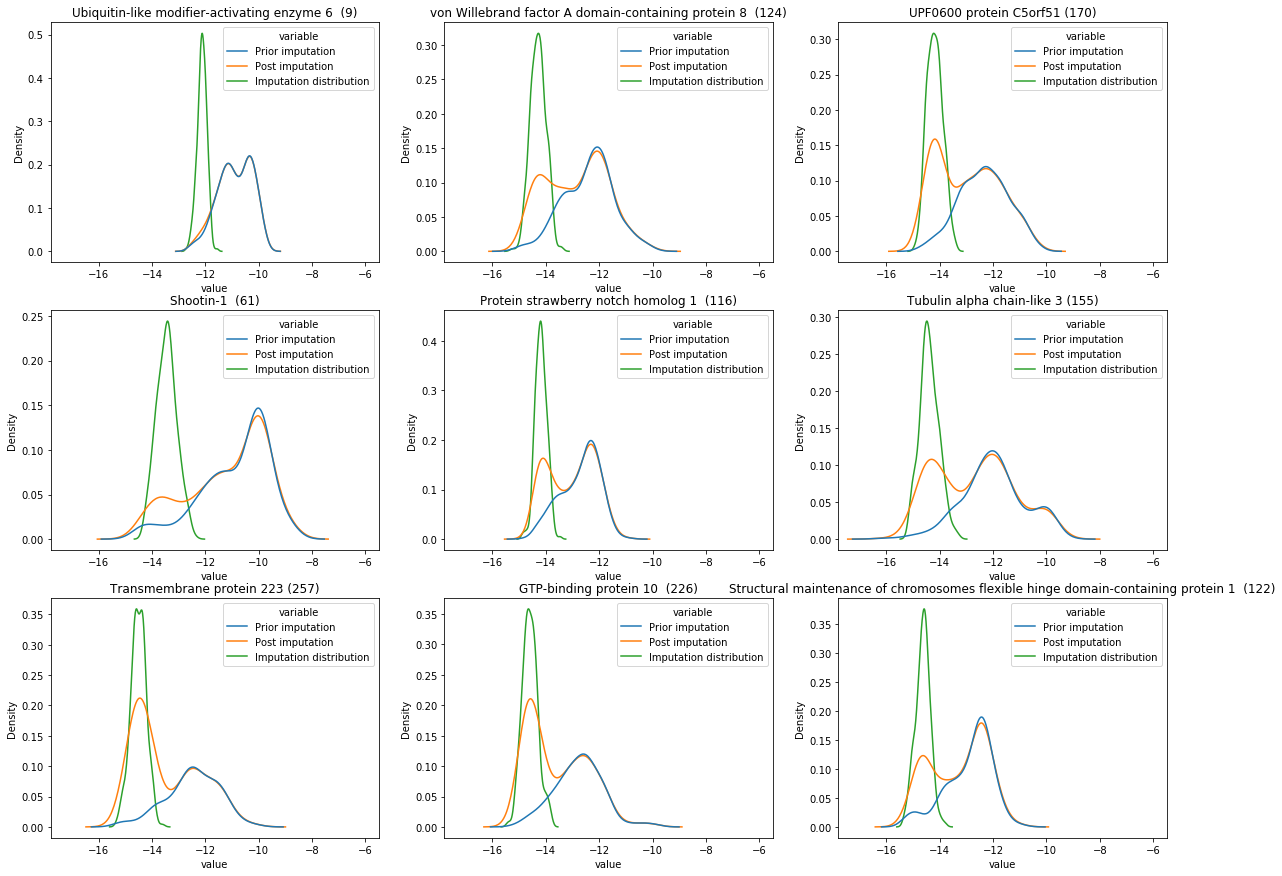

In [11]:
# The new imputation method

fig, (ax1,ax2,ax3) = plt.subplots(3,3, figsize=(20,15))

for i, axes in enumerate([ax1,ax2,ax3]):
    
     
    prot = lwvig_imputer.mean_std_df.index[i]
    m = lwvig_imputer.mean_std_df.loc[prot, "mean"]
    s = lwvig_imputer.mean_std_df.loc[prot, "std"]
    
    mv_indices = data_quantile.loc[data_quantile.loc[:,prot].isna()].index
    nmv_indices = data_quantile[~data_quantile.index.isin(mv_indices)].index

    samples = np.random.normal(m - 2*s, s*.3, 300)
    axes[0].set_title(f"{uniprot_description.loc[protein_names[prot]].description} ({len(mv_indices)})")
    axes[0].set_xlim((-17.8, -5.5))
    axes[1].set_xlim((-17.8, -5.5))
    axes[2].set_xlim((-17.8, -5.5))

    non_imputed = data_quantile.loc[:,prot]
    non_imputed.name = "Prior imputation"
    imputed = imputed_quant.loc[:,prot]
    imputed.name = "Post imputation"
    sns.kdeplot(data=pd.concat([non_imputed, imputed, pd.Series(samples, name="Imputation distribution")],axis=1).melt().dropna(), x="value",hue="variable", common_norm=True, ax=axes[0])

    prot = lwvig_imputer.mean_std_df.index[i+5]
    m = lwvig_imputer.mean_std_df.loc[prot, "mean"]
    s = lwvig_imputer.mean_std_df.loc[prot, "std"]
    
    mv_indices = data_quantile.loc[data_quantile.loc[:,prot].isna()].index
    nmv_indices = data_quantile[~data_quantile.index.isin(mv_indices)].index

    samples = np.random.normal(m - 2*s, s*.3, 300)
    axes[1].set_title(f"{uniprot_description.loc[protein_names[prot]].description} ({len(mv_indices)})")
    
    non_imputed = data_quantile.loc[:,prot]
    non_imputed.name = "Prior imputation"
    imputed = imputed_quant.loc[:,prot]
    imputed.name = "Post imputation"
    sns.kdeplot(data=pd.concat([non_imputed, imputed, pd.Series(samples, name="Imputation distribution")],axis=1).melt().dropna(), x="value",hue="variable", common_norm=True, ax=axes[1])
    
    prot = lwvig_imputer.mean_std_df.index[i+10]
    m = lwvig_imputer.mean_std_df.loc[prot, "mean"]
    s = lwvig_imputer.mean_std_df.loc[prot, "std"]
    
    mv_indices = data_quantile.loc[data_quantile.loc[:,prot].isna()].index
    nmv_indices = data_quantile[~data_quantile.index.isin(mv_indices)].index

    samples = np.random.normal(m - 2*s, s*.3, 300)
    axes[2].set_title(f"{uniprot_description.loc[protein_names[prot]].description} ({len(mv_indices)})")
    
    non_imputed = data_quantile.loc[:,prot]
    non_imputed.name = "Prior imputation"
    imputed = imputed_quant.loc[:,prot]
    imputed.name = "Post imputation"
    sns.kdeplot(data=pd.concat([non_imputed, imputed, pd.Series(samples, name="Imputation distribution")],axis=1).melt().dropna(), x="value",hue="variable", common_norm=True, ax=axes[2])

In [12]:
# PCA, PCA+LOD, original
lod_effect_corr = []
lod_effect_mse = []
for x in range(20):
    print("cycle:", x+1)

    mnar_mcar_imputer = uml.MNAR_MCAR_Imputer(max_iter=15)
    mnar_mcar_imputer.fit(data_quantile, labels)
    combination_quantile = mnar_mcar_imputer.transform(data_quantile, labels)

    pca_quantile, _, _ = uml.PCA_imputation(dataset= data_quantile, max_iter=15)

    lod_effect_corr.append(pearsonr(combination_quantile.melt().loc[mnar_mcar_imputer.pca_knn_mv_indices, "value"], pca_quantile.melt().loc[mnar_mcar_imputer.pca_knn_mv_indices, "value"])[0])
    lod_effect_mse.append(mean_squared_error(combination_quantile.melt().loc[mnar_mcar_imputer.pca_knn_mv_indices, "value"], pca_quantile.melt().loc[mnar_mcar_imputer.pca_knn_mv_indices, "value"]))

cycle: 1
First iteration: 0
iteration: 0
Components: 317
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
First iteration: 0
iteration: 0
Components: 327
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
cycle: 2
First iteration: 0
iteration: 0
Components: 317
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
First iteration: 0
iteration: 0
Components: 327
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
cycle: 3
First iteration: 0
iteration: 0
C

In [14]:
print(np.mean(lod_effect_corr), np.std(lod_effect_corr))
print(np.mean(lod_effect_mse), np.std(lod_effect_mse))

0.8933168392348655 0.0005731893931065996
0.2856747418784083 0.001297791975372544


How are the MCAR values differently estimated by PCA if LOD is added?

In [16]:
pearsonr(combination_quantile.melt().loc[mnar_mcar_imputer.pca_knn_mv_indices, "value"], pca_quantile.melt().loc[mnar_mcar_imputer.pca_knn_mv_indices, "value"])

(0.8933893547780761, 0.0)

In [15]:
mean_squared_error(combination_quantile.melt().loc[mnar_mcar_imputer.pca_knn_mv_indices, "value"], pca_quantile.melt().loc[mnar_mcar_imputer.pca_knn_mv_indices, "value"])

0.2855004096133512

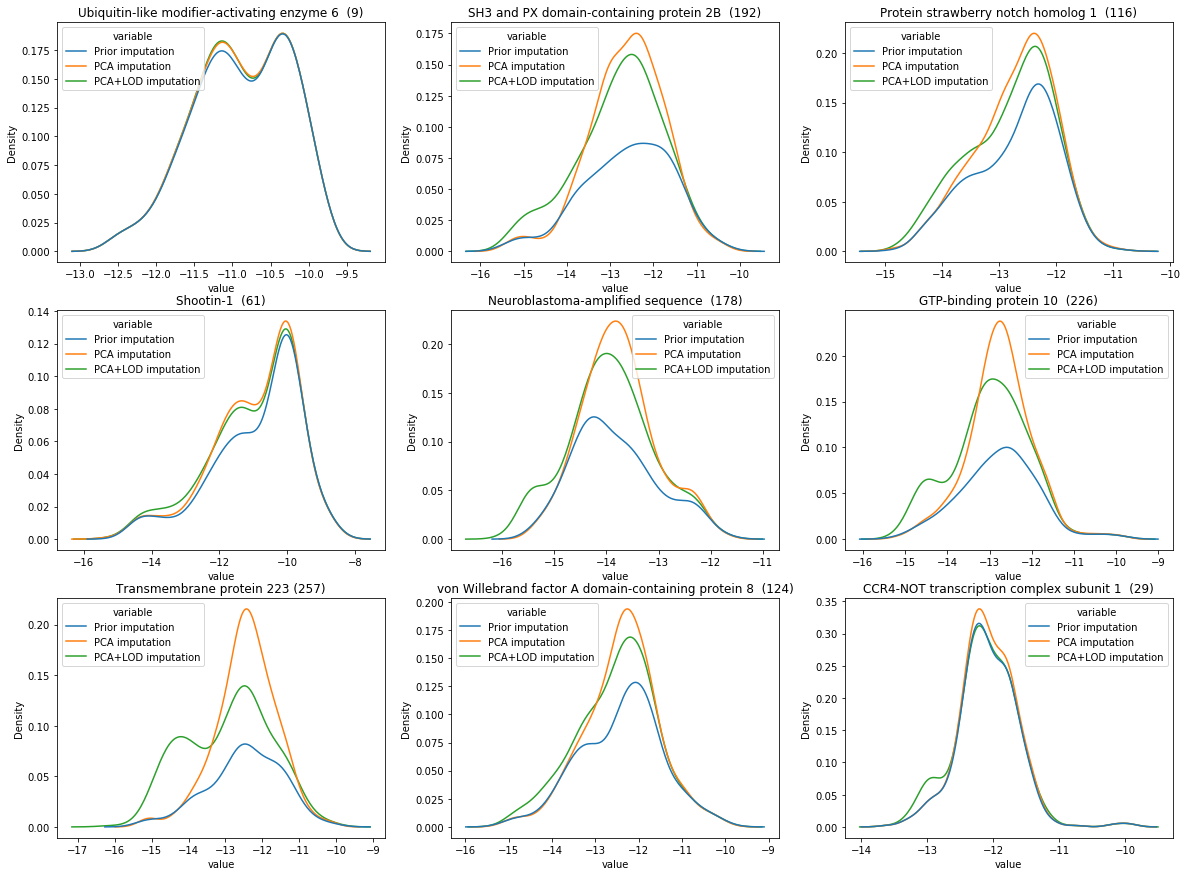

In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(3,3, figsize=(20,15))

for i, axes in enumerate([ax1,ax2,ax3]):
    
     
    prot = lwvig_imputer.mean_std_df.index[i]
    m = lwvig_imputer.mean_std_df.loc[prot, "mean"]
    s = lwvig_imputer.mean_std_df.loc[prot, "std"]
    
    mv_indices = data_quantile.loc[data_quantile.loc[:,prot].isna()].index
    nmv_indices = data_quantile[~data_quantile.index.isin(mv_indices)].index

    axes[0].set_title(f"{uniprot_description.loc[protein_names[prot]].description} ({len(mv_indices)})")
    
    non_imputed = data_quantile.loc[:,prot]
    non_imputed.name = "Prior imputation"
    imputed = pca_quantile.loc[:,prot]
    imputed.name = "PCA imputation"

    imputed_comb = combination_quantile.loc[:,prot]
    imputed_comb.name = "PCA+LOD imputation"
    sns.kdeplot(data=pd.concat([non_imputed, imputed, imputed_comb],axis=1).melt().dropna(), x="value",hue="variable", common_norm=True, ax=axes[0])

    prot = lwvig_imputer.mean_std_df.index[i+3]
    m = lwvig_imputer.mean_std_df.loc[prot, "mean"]
    s = lwvig_imputer.mean_std_df.loc[prot, "std"]
    
    mv_indices = data_quantile.loc[data_quantile.loc[:,prot].isna()].index
    nmv_indices = data_quantile[~data_quantile.index.isin(mv_indices)].index

    axes[1].set_title(f"{uniprot_description.loc[protein_names[prot]].description} ({len(mv_indices)})")
    
    non_imputed = data_quantile.loc[:,prot]
    non_imputed.name = "Prior imputation"
    imputed = pca_quantile.loc[:,prot]
    imputed.name = "PCA imputation"

    imputed_comb = combination_quantile.loc[:,prot]
    imputed_comb.name = "PCA+LOD imputation"
    sns.kdeplot(data=pd.concat([non_imputed, imputed, imputed_comb],axis=1).melt().dropna(), x="value",hue="variable", common_norm=True, ax=axes[1])
    
    prot = lwvig_imputer.mean_std_df.index[i+6]
    m = lwvig_imputer.mean_std_df.loc[prot, "mean"]
    s = lwvig_imputer.mean_std_df.loc[prot, "std"]
    
    mv_indices = data_quantile.loc[data_quantile.loc[:,prot].isna()].index
    nmv_indices = data_quantile[~data_quantile.index.isin(mv_indices)].index

    axes[2].set_title(f"{uniprot_description.loc[protein_names[prot]].description} ({len(mv_indices)})")
    
    non_imputed = data_quantile.loc[:,prot]
    non_imputed.name = "Prior imputation"
    imputed = pca_quantile.loc[:,prot]
    imputed.name = "PCA imputation"

    imputed_comb = combination_quantile.loc[:,prot]
    imputed_comb.name = "PCA+LOD imputation"
    sns.kdeplot(data=pd.concat([non_imputed, imputed, imputed_comb],axis=1).melt().dropna(), x="value",hue="variable", common_norm=True, ax=axes[2])

How does PCA-imputation change each cycle

In [118]:
from scipy import stats

In [93]:
all_mv_indices = data_quantile.melt()[data_quantile.melt().loc[:, "value"].isna()].index

In [ ]:
pca_imputations = []
for i in range(20):
    print(f"cycle {i+1}")
    mnar_mcar_imputer = uml.MNAR_MCAR_Imputer(max_iter=15)
    mnar_mcar_imputer.fit(data_quantile, labels)
    combination_quantile = mnar_mcar_imputer.transform(data_quantile, labels)

    pca_imputations.append(list(combination_quantile.melt().loc[mnar_mcar_imputer.pca_knn_mv_indices, "value"]))

In [124]:
pca_errors = []
pca_correlations=[]
for i1,i2 in combinations(range(20),2):
    pca_errors.append(mean_squared_error(y_true= pca_imputations[i1],y_pred =pca_imputations[i2]))
    pca_correlations.append(stats.pearsonr(x=pca_imputations[i1], y=pca_imputations[i2])[0])

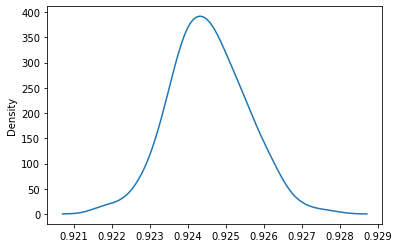

In [125]:
sns.kdeplot(pca_correlations)

In [132]:
np.mean(pca_correlations)

0.9245305356863941

In [107]:
gaussian_imputations = []
for i in range(20):
    lwvig_imputer = uml.LowestValueImputerGaussian()
    lwvig_imputer.fit_transform(data_quantile)
    imputed_quant = lwvig_imputer.transform(data_quantile)
    gaussian_imputations.append(list(imputed_quant.melt().loc[all_mv_indices, "value"]))

In [126]:
gaussian_errors = []
gaussian_correlations = []
for i1,i2 in combinations(range(20),2):
    gaussian_errors.append(mean_squared_error(y_true= gaussian_imputations[i1],y_pred =gaussian_imputations[i2]))
    gaussian_correlations.append(stats.pearsonr(x=gaussian_imputations[i1], y=gaussian_imputations[i2])[0])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


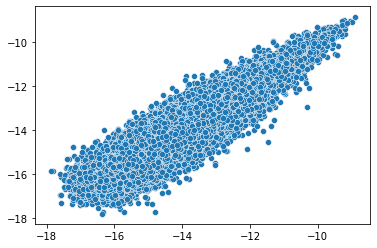

In [128]:
sns.scatterplot(gaussian_imputations[i1], gaussian_imputations[i2])

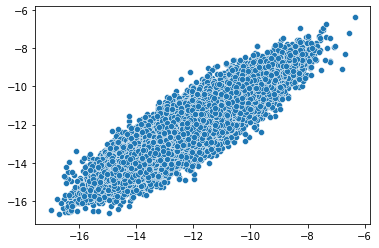

In [131]:
sns.scatterplot(pca_imputations[i1], pca_imputations[i2])

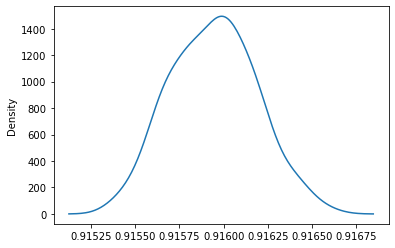

In [127]:
sns.kdeplot(gaussian_correlations)

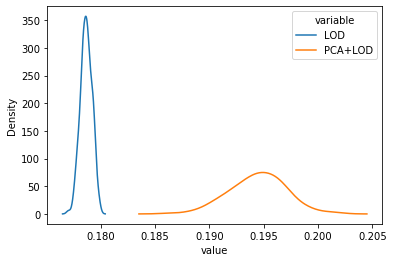

In [117]:
sns.kdeplot(data=pd.concat([pd.Series(gaussian_errors, name="LOD"), pd.Series(pca_errors, name="PCA+LOD")],axis=1).melt(),
            x="value", hue="variable")

In [88]:
from scipy import stats
stats.pearsonr(x=imputations[0], y=imputations[1])

(0.9252067217471072, 0.0)

---

In [3]:
mapper = zip(meta.PXD_accession.unique(), sns.color_palette("pastel", n_colors=meta.PXD_accession.nunique()))
mapper = dict(mapper)

In [87]:
# Equivalent to zero-imputation but protein-wise
class LowestValueImputer(BaseEstimator, TransformerMixin):
    '''
    Imputes the lowest value in that column
    '''

    def __init__(self):
        self.fitted = False

    def fit(self, X, y = None):
        self.impute_map = X.min()

        # If protein columns has all nans, impute the lowest value in the dataframe
        self.impute_map = self.impute_map.fillna(self.impute_map.min())
        return self

    def transform(self, X, y=None):
        check_is_fitted(self, 'impute_map')
        
        X = X.copy()

        for index, row in self.impute_map.iteritems():
            ind = X.index[X.loc[:,index].isna()]
            X.loc[ind, index] = X.loc[ind, index].fillna(self.impute_map[index])
        
        return X

In [4]:
# Variant of zero-imputation: left shifted gaussian, similar to the one implemented in Perseus (https://www.nature.com/articles/nmeth.3901)
class LowestValueImputerGaussian(BaseEstimator, TransformerMixin):
    '''
    Imputes by sampling from left shifted Gaussian distribution. Imputes 0 if protein was not identified in 50% of samples belonging to the class
    '''

    def __init__(self, mean_shift=2, std_scale=0.3, lowest_val = False):
        self.fitted = False
        self.mean_shift = mean_shift
        self.std_scale = std_scale
        self.lowest_val = lowest_val
        self.imputed_values = {}
    
    def fit(self, X, y=None):
        
        X = pd.DataFrame(X)
        self.mean_std_df = pd.DataFrame({"mean": X.mean(), "std": X.std()})

        #imputed_data = X.apply(lambda x: self.impute(x), axis=1)

        return self

    def transform(self, X, y=None):
        check_is_fitted(self, 'mean_std_df')

        X_imputed = pd.DataFrame(X, columns=self.mean_std_df.index).copy()

        # Create imputation matrix
        imputation_matrix = []
        for i in self.mean_std_df.index:
            m, s = self.mean_std_df.loc[i]
            imputation_matrix.append(np.random.normal(m-self.mean_shift*s, s*self.std_scale, size=len(X)))
        imputation_matrix = pd.DataFrame(data=imputation_matrix, index=self.mean_std_df.index).T

        if self.lowest_val:
            imputation_matrix.where(imputation_matrix>self.lowest_val, other = self.lowest_val, inplace=True)

        for i in X_imputed.columns:
            X_imputed[i].fillna(imputation_matrix[i], inplace=True)
        
        return X_imputed

In [5]:
# Initialize random values
def PCA_imputation(dataset, explained_variance=.95, max_iter=50, keep_PC_constant = True, get_knn_corr=False):
    '''Accepts non minmax normalized dataset'''

    dataset = dataset.reset_index(drop=True).rename(columns={dataset.columns[x]:x for x in range(len(dataset.columns))})
    mm_scaler = MinMaxScaler()
    scaled_dataset = pd.DataFrame(mm_scaler.fit_transform(dataset))
    non_MV_indices = dataset.melt()["value"].dropna().index
    MV_indices = dataset.melt().index[dataset.melt().isna()["value"]]
    MSEs = []
    MSEs_unrescaled = []
    corr_PCA_KNN = []

    if get_knn_corr:
        knn_imputer = KNNImputer(n_neighbors=10, weights="distance")
        X_knn_imputed = knn_imputer.fit_transform(scaled_dataset)
        X_knn_imputed = pd.DataFrame(mm_scaler.inverse_transform(X_knn_imputed))
        mv_knn = X_knn_imputed.melt().loc[MV_indices, 'value']

    for i in range(max_iter):

        # Initialize missing values with mean imputation
        if i == 0:
            scaler = MinMaxScaler()
            dataset_scaled = scaler.fit_transform(dataset)
            mean_imputation = SimpleImputer(strategy='mean')
            X_imputed = mean_imputation.fit_transform(dataset_scaled)
            print("First iteration:", i)

        # Else use the calculated PC imputation and iterate
        else:
            # Scale data
            scaler = MinMaxScaler()
            X_imputed = scaler.fit_transform(X_imputed)

        
        print("iteration:", i)
        # Select component explaining 95% of the data 
        if not keep_PC_constant or (i ==0):  
            pca_model = PCA()
            embedded = pca_model.fit_transform(X_imputed)
            components_to_keep = sum(np.cumsum(pca_model.explained_variance_ratio_) < explained_variance)
            print('Components:', components_to_keep)

        # Refit and reconstruct
        pca_model = PCA(n_components=components_to_keep)
        embedded = pca_model.fit_transform(X_imputed)
        reconstructed = pca_model.inverse_transform(embedded)

        # Standardise back
        rescaled_reconstructed = scaler.inverse_transform(reconstructed)
        rescaled_reconstructed = pd.DataFrame(rescaled_reconstructed)

        # Fill in new dataframe with computed missing values retaining non-missing values
        X_imputed = dataset.copy()
        for i in X_imputed.columns:
            X_imputed[i].fillna(rescaled_reconstructed[i], inplace=True)
        
        # Compute reconstruction error with MSE of the observed values only. This is done by setting the missing values to same value in both dataframes (original and reconstructed)
        MSE_unrescaled = mean_squared_error(scaled_dataset.melt()["value"].dropna(), pd.DataFrame(reconstructed).melt()["value"][non_MV_indices])
        MSEs_unrescaled.append(MSE_unrescaled)

        MSE = mean_squared_error(dataset.melt()["value"].dropna(), rescaled_reconstructed.melt()["value"][non_MV_indices])
        MSEs.append(MSE)

        if get_knn_corr:
            mv_pca = rescaled_reconstructed.melt().loc[MV_indices, 'value']
            corr_PCA_KNN.append(pearsonr(mv_knn, mv_pca)[0])

    if get_knn_corr:
        return X_imputed, MSEs, MSEs_unrescaled, corr_PCA_KNN

    return X_imputed, MSEs, MSEs_unrescaled

In [137]:
missing_value_mask = data_nsaf.isna()
data_combat = data_combat.where(~missing_value_mask, other=np.nan)

In [81]:
imputer_quant = Pipeline(steps=[
    ("Scaling", MinMaxScaler()),
    ("imputer", LowestValueImputerGaussian(lowest_val=0))])
imputer_nsaf = Pipeline(steps=[
    ("Scaling", MinMaxScaler()),
    ("imputer", LowestValueImputerGaussian(lowest_val=0))])
imputer_median_norm = Pipeline(steps=[
    ("Scaling", MinMaxScaler()),
    ("imputer", LowestValueImputerGaussian(lowest_val=0))])

In [82]:
imputer_quant_fitted = imputer_quant.fit(data_quantile)
imputer_nsaf_fitted = imputer_nsaf.fit(data_nsaf)
imputer_median_norm_fitted = imputer_median_norm.fit(data_median_norm)

In [83]:
# Runtime for 3 cycles: approx 12.7 seconds
imputed_quantile = imputer_quant.transform(data_quantile)
print("imputed Quant")
imputed_nsaf = imputer_nsaf.transform(data_nsaf)
print("imputed nsaf")
imputed_median_norm = imputer_median_norm.transform(data_median_norm)
print("imputed mednorm")

imputed Quant
imputed nsaf
imputed mednorm


In [92]:
nsaf_scaler = MinMaxScaler()
quantile_scaler = MinMaxScaler()
median_norm_scaler = MinMaxScaler()
combat_scaler = MinMaxScaler()

minmax_nsaf = pd.DataFrame(nsaf_scaler.fit_transform(data_nsaf))
minmax_quantile = pd.DataFrame(quantile_scaler.fit_transform(data_quantile))
minmax_median_norm = pd.DataFrame(median_norm_scaler.fit_transform(data_median_norm))
minmax_combat = pd.DataFrame(combat_scaler.fit_transform(data_combat))

In [94]:
reindexed_missing_value_mask = missing_value_mask.reset_index(drop=True).rename(columns={missing_value_mask.columns[x]:x for x in range(len(missing_value_mask.columns))})

In [95]:
# KNN imputation is deterministic, check if transposing generates other values

#NSAF
print("Fittin NSAF")
imputer_knn_T = KNNImputer(n_neighbors=10, weights='distance')
knn_nsaf_T = imputer_knn_T.fit_transform(minmax_nsaf.T)
knn_nsaf_protein = pd.DataFrame(knn_nsaf_T.T)

imputer_knn = KNNImputer(n_neighbors=10, weights='distance')
knn_nsaf = imputer_knn.fit_transform(minmax_nsaf)
knn_nsaf_sample = pd.DataFrame(knn_nsaf)

# Quantile norm
print("Fitting Quantile")
imputer_knn_T = KNNImputer(n_neighbors=10, weights='distance')
knn_quantile_T = imputer_knn_T.fit_transform(minmax_quantile.T)
knn_quantile_protein = pd.DataFrame(knn_quantile_T.T)

imputer_knn = KNNImputer(n_neighbors=10, weights='distance')
knn_quantile = imputer_knn.fit_transform(minmax_quantile)
knn_quantile_sample = pd.DataFrame(knn_quantile)

# Combat
print("Fitting ComBat")
imputer_knn_T = KNNImputer(n_neighbors=10, weights='distance')
knn_combat_T = imputer_knn_T.fit_transform(minmax_combat.T)
knn_combat_protein = pd.DataFrame(knn_combat_T.T)

imputer_knn = KNNImputer(n_neighbors=10, weights='distance')
knn_combat = imputer_knn.fit_transform(minmax_combat)
knn_combat_sample = pd.DataFrame(knn_combat)

# Med norm
print('Fitting mednorm')
imputer_knn_T = KNNImputer(n_neighbors=10, weights='distance')
knn_med_T = imputer_knn_T.fit_transform(minmax_median_norm.T)
knn_med_protein = pd.DataFrame(knn_med_T.T)

imputer_knn = KNNImputer(n_neighbors=10, weights='distance')
knn_med = imputer_knn.fit_transform(minmax_median_norm)
knn_med_sample = pd.DataFrame(knn_med)

Fittin NSAF
Fitting Quantile
Fitting ComBat
Fitting mednorm


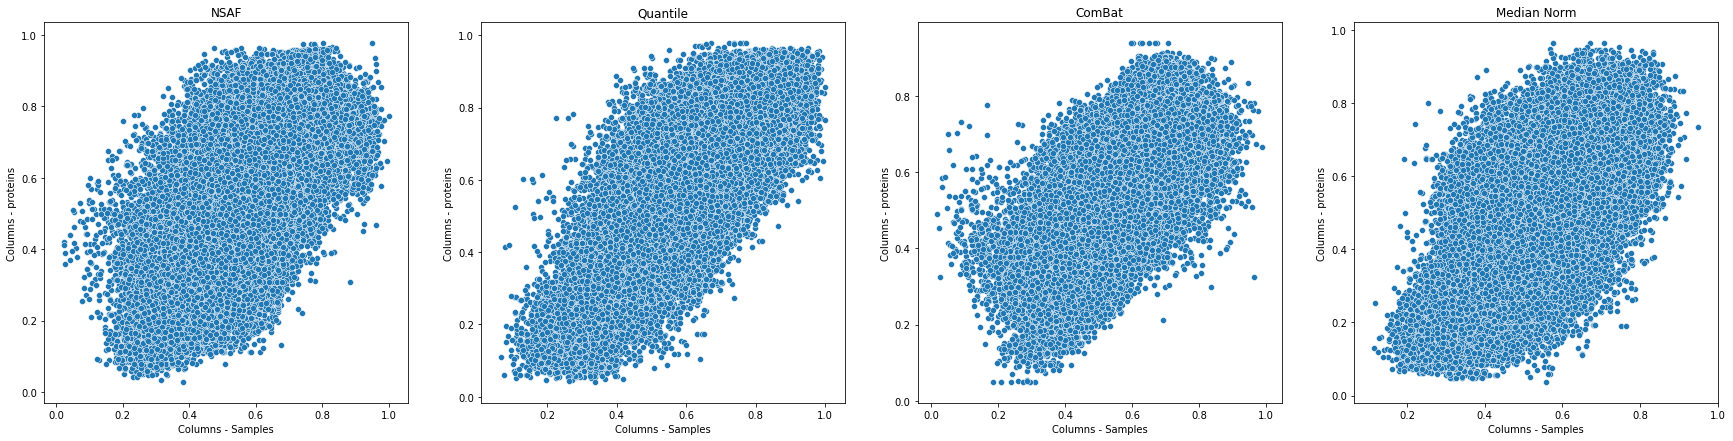

In [96]:
MVs_prot_nsaf = []
MVs_sample_nsaf = []
MVs_prot_quantile = []
MVs_sample_quantile = []
MVs_prot_combat = []
MVs_sample_combat = []
MVs_prot_med = []
MVs_sample_med = []

for i in knn_nsaf_protein.index:
    MVs_prot_nsaf += list(knn_nsaf_protein.loc[i,:][reindexed_missing_value_mask.loc[i,:]])
    MVs_sample_nsaf += list(knn_nsaf_sample.loc[i,:][reindexed_missing_value_mask.loc[i,:]])

    MVs_prot_quantile += list(knn_quantile_protein.loc[i,:][reindexed_missing_value_mask.loc[i,:]])
    MVs_sample_quantile += list(knn_quantile_sample.loc[i,:][reindexed_missing_value_mask.loc[i,:]])

    MVs_prot_combat += list(knn_combat_protein.loc[i,:][reindexed_missing_value_mask.loc[i,:]])
    MVs_sample_combat += list(knn_combat_sample.loc[i,:][reindexed_missing_value_mask.loc[i,:]])

    MVs_prot_med += list(knn_med_protein.loc[i,:][reindexed_missing_value_mask.loc[i,:]])
    MVs_sample_med += list(knn_med_sample.loc[i,:][reindexed_missing_value_mask.loc[i,:]])

fig, ax = plt.subplots(1,4, figsize=(30,7))

titles = ["NSAF", "Quantile", "ComBat", "Median Norm"]
MVs_prot = [MVs_prot_nsaf, MVs_prot_quantile, MVs_prot_combat, MVs_prot_med]
MVs_sample = [MVs_sample_nsaf, MVs_sample_quantile, MVs_sample_combat, MVs_sample_med]
for i,ax_ in enumerate(ax):

    ax_.set_title(titles[i])
    ax_.set_xlabel("Columns - Samples")
    ax_.set_ylabel("Columns - proteins")

    sns.scatterplot(x=MVs_prot[i], y=MVs_sample[i], ax=ax_)

In [25]:
pca_combat, MSEs_combat, MSEs_combat_scaled, knn_pca_corr_combat = PCA_imputation(data_combat, max_iter=50, get_knn_corr=True, keep_PC_constant=False)

First iteration: 0
iteration: 0
Components: 367
iteration: 1
Components: 340
iteration: 2
Components: 324
iteration: 3
Components: 313
iteration: 4
Components: 305
iteration: 5
Components: 298
iteration: 6
Components: 292
iteration: 7
Components: 287
iteration: 8
Components: 283
iteration: 9
Components: 279
iteration: 10
Components: 276
iteration: 11
Components: 273
iteration: 12
Components: 270
iteration: 13
Components: 267
iteration: 14
Components: 265
iteration: 15
Components: 263
iteration: 16
Components: 261
iteration: 17
Components: 259
iteration: 18
Components: 257
iteration: 19
Components: 255
iteration: 20
Components: 254
iteration: 21
Components: 252
iteration: 22
Components: 251
iteration: 23
Components: 250
iteration: 24
Components: 248
iteration: 25
Components: 247
iteration: 26
Components: 246
iteration: 27
Components: 245
iteration: 28
Components: 244
iteration: 29
Components: 243
iteration: 30
Components: 242
iteration: 31
Components: 241
iteration: 32
Components: 240
i

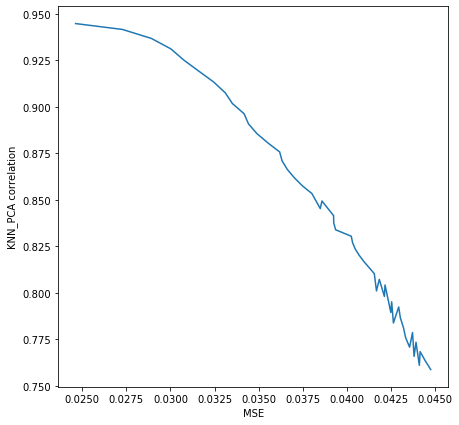

In [26]:
plt.figure(figsize=(7,7))
sns.lineplot(data=pd.DataFrame(data={'MSE': MSEs_combat, "KNN_PCA correlation": knn_pca_corr_combat}), x='MSE', y='KNN_PCA correlation')

In [104]:
MSE_PC = {"PC": [], 'MSE': []}
for components in range(2,500):
    pca = PCA(n_components=components)
    embedding = pca.fit_transform(minmax_combat)
    reconstructed = pca.inverse_transform(embedding)

    MSE = mean_squared_error(minmax_combat, reconstructed)
    MSE_PC['MSE'].append(MSE)
    MSE_PC['PC'].append(components)

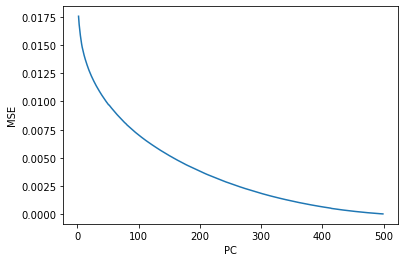

In [105]:
sns.lineplot(data=MSE_PC, x='PC', y="MSE")

In [28]:
# Runtime: approx 1 minute for 20 iterations; 15 minutes for 200
pca_quant, MSEs_quant, MSEs_quant_scaled = PCA_imputation(data_quantile, max_iter=15)
pca_nsaf, MSEs_nsaf, MSEs_nsaf_scaled = PCA_imputation(data_nsaf, max_iter=15)
pca_med_norm, MSEs_med_norm, MSEs_med_scaled = PCA_imputation(data_median_norm, max_iter=15)
pca_combat, MSEs_combat, MSEs_combat_scaled = PCA_imputation(data_combat, max_iter=15)

First iteration: 0
iteration: 0
Components: 327
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
First iteration: 0
iteration: 0
Components: 341
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
First iteration: 0
iteration: 0
Components: 346
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
First iteration: 0
iteration: 0
Components: 367
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14


In [164]:
pca_quant_, MSEs_quant_, MSEs_quant_scaled_ = PCA_imputation(data_quantile, keep_PC_constant=False)
pca_nsaf_, MSEs_nsaf_, MSEs_nsaf_scaled_ = PCA_imputation(data_nsaf, keep_PC_constant=False)
pca_med_norm_, MSEs_med_norm_, MSEs_med_scaled_ = PCA_imputation(data_median_norm, keep_PC_constant=False)
pca_combat_, MSEs_combat_, MSEs_combat_scaled_ = PCA_imputation(data_combat, keep_PC_constant=False)

iteration: 0
Components: 327
iteration: 1
Components: 291
iteration: 2
Components: 273
iteration: 3
Components: 261
iteration: 4
Components: 253
iteration: 5
Components: 246
iteration: 6
Components: 241
iteration: 7
Components: 237
iteration: 8
Components: 234
iteration: 9
Components: 231
iteration: 10
Components: 228
iteration: 11
Components: 226
iteration: 12
Components: 224
iteration: 13
Components: 222
iteration: 14
Components: 220
iteration: 15
Components: 219
iteration: 16
Components: 217
iteration: 17
Components: 216
iteration: 18
Components: 214
iteration: 19
Components: 213
iteration: 20
Components: 212
iteration: 21
Components: 211
iteration: 22
Components: 210
iteration: 23
Components: 209
iteration: 24
Components: 208
iteration: 25
Components: 207
iteration: 26
Components: 206
iteration: 27
Components: 205
iteration: 28
Components: 205
iteration: 29
Components: 204
iteration: 30
Components: 203
iteration: 31
Components: 203
iteration: 32
Components: 202
iteration: 33
Compon

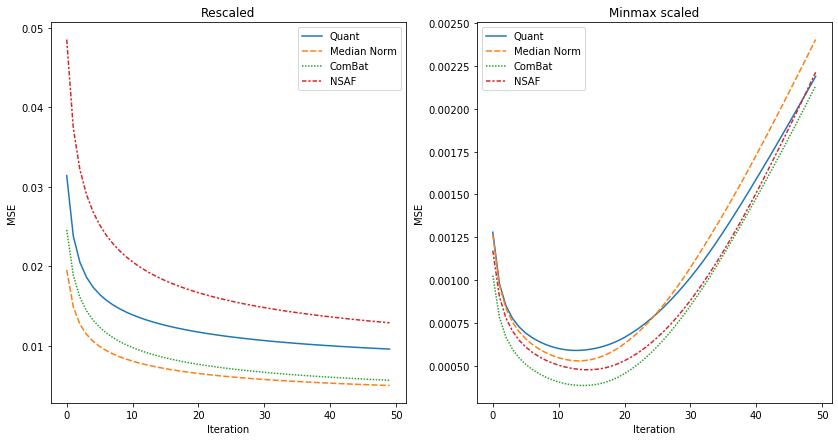

In [160]:
MSEs = {"Quant": MSEs_quant, "Median Norm": MSEs_med_norm, "ComBat": MSEs_combat, "NSAF": MSEs_nsaf}
MSEs_scaled = {"Quant": MSEs_quant_scaled, "Median Norm": MSEs_med_scaled, "ComBat": MSEs_combat_scaled, "NSAF": MSEs_nsaf_scaled}

fig, ax = plt.subplots(1,2,figsize=(14,7))
ax[0].set_title("Rescaled")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("MSE")
ax[1].set_title("Minmax scaled")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("MSE")
sns.lineplot(data=pd.DataFrame(MSEs), ax=ax[0])
sns.lineplot(data=pd.DataFrame(MSEs_scaled), ax=ax[1])

In [ ]:
MSEs = {"Quant": MSEs_quant, "Median Norm": MSEs_med_norm, "ComBat": MSEs_combat, "NSAF": MSEs_nsaf}
MSEs_scaled = {"Quant": MSEs_quant_scaled, "Median Norm": MSEs_med_scaled, "ComBat": MSEs_combat_scaled, "NSAF": MSEs_nsaf_scaled}

fig, ax = plt.subplots(1,2,figsize=(14,7))
ax[0].set_title("Rescaled")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("MSE")
ax[1].set_title("Minmax scaled")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("MSE")
sns.lineplot(data=pd.DataFrame(MSEs), ax=ax[0])
sns.lineplot(data=pd.DataFrame(MSEs_scaled), ax=ax[1])

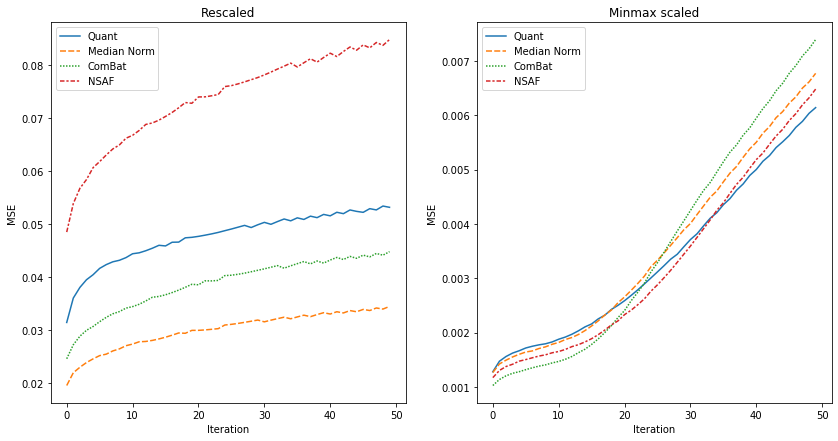

In [165]:
# Using the loop as described in the paper: loss is increasing...

MSEs_ = {"Quant": MSEs_quant_, "Median Norm": MSEs_med_norm_, "ComBat": MSEs_combat_, "NSAF": MSEs_nsaf_}
MSEs_scaled_ = {"Quant": MSEs_quant_scaled_, "Median Norm": MSEs_med_scaled_, "ComBat": MSEs_combat_scaled_, "NSAF": MSEs_nsaf_scaled_}

fig, ax = plt.subplots(1,2,figsize=(14,7))
ax[0].set_title("Rescaled")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("MSE")
ax[1].set_title("Minmax scaled")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("MSE")
sns.lineplot(data=pd.DataFrame(MSEs_), ax=ax[0])
sns.lineplot(data=pd.DataFrame(MSEs_scaled_), ax=ax[1])

In [119]:
mv_indices = data_quantile.melt()["value"].index[data_quantile.melt()["value"].isna()]

In [10]:
def calc_corr_KNN_PCA(knn_protein, knn_sample, pca_dataset, data_norm, scaler):
    """knn_protein: imputed dataset with knn_T; others are similar"""

    fig, ax = plt.subplots(1,2, figsize= (30,7))
    for ax_ in ax:    
        ax_.set_xlabel("KNN")
        ax_.set_ylabel("PCA")

    ax[0].set_title(f"KNN-T - PCA missing values {data_norm}")
    ax[1].set_title(f"KNN - PCA missing values {data_norm}")

    mv_KNN_T = pd.DataFrame(scaler.inverse_transform(knn_protein)).melt().loc[mv_indices, 'value']
    mv_KNN = pd.DataFrame(scaler.inverse_transform(knn_sample)).melt().loc[mv_indices, 'value']
    mv_PCA = pca_dataset.melt().loc[mv_indices, 'value']
    corr_knnT_PCA = pearsonr(mv_KNN_T, mv_PCA)
    corr_knn_PCA = pearsonr(mv_KNN, mv_PCA)

    sns.scatterplot(x=mv_KNN_T, y = mv_PCA, ax=ax[0])
    sns.scatterplot(x=mv_KNN, y = mv_PCA, ax=ax[1])

    print(data_norm,"(pearson KNN-T - PCA): ",  corr_knnT_PCA)
    print(data_norm,"(pearson KNN - PCA): ",  corr_knn_PCA)

    return corr_knnT_PCA[0], corr_knn_PCA[0]

In [162]:
print("Abundance range NSAF (min-max)", data_nsaf.min().min(), data_nsaf.max().max())
print("Abundance range Quant (min-max)", data_quantile.min().min(), data_quantile.max().max())
print("Abundance range ComBat (min-max)", data_combat.min().min(), data_combat.max().max())
print("Abundance range MedNorm (min-max)", data_median_norm.min().min(), data_median_norm.max().max())

Abundance range NSAF (min-max) -21.239840494485783 -1.8982199439559029
Abundance range Quant (min-max) -17.876127106474033 -5.565812695277335
Abundance range ComBat (min-max) -20.19993291887573 -4.066847892346557
Abundance range MedNorm (min-max) -7.12712540425852 4.9631629509148745


NSAF (pearson KNN-T - PCA):  (0.667520952216109, 0.0)
NSAF (pearson KNN - PCA):  (0.6662266540271952, 0.0)
Quantile (pearson KNN-T - PCA):  (0.6289204559115693, 0.0)
Quantile (pearson KNN - PCA):  (0.6328735463176149, 0.0)
ComBat (pearson KNN-T - PCA):  (0.8072255318046627, 0.0)
ComBat (pearson KNN - PCA):  (0.814969984000712, 0.0)
Median Norm (pearson KNN-T - PCA):  (0.6863787408183701, 0.0)
Median Norm (pearson KNN - PCA):  (0.681924079734141, 0.0)


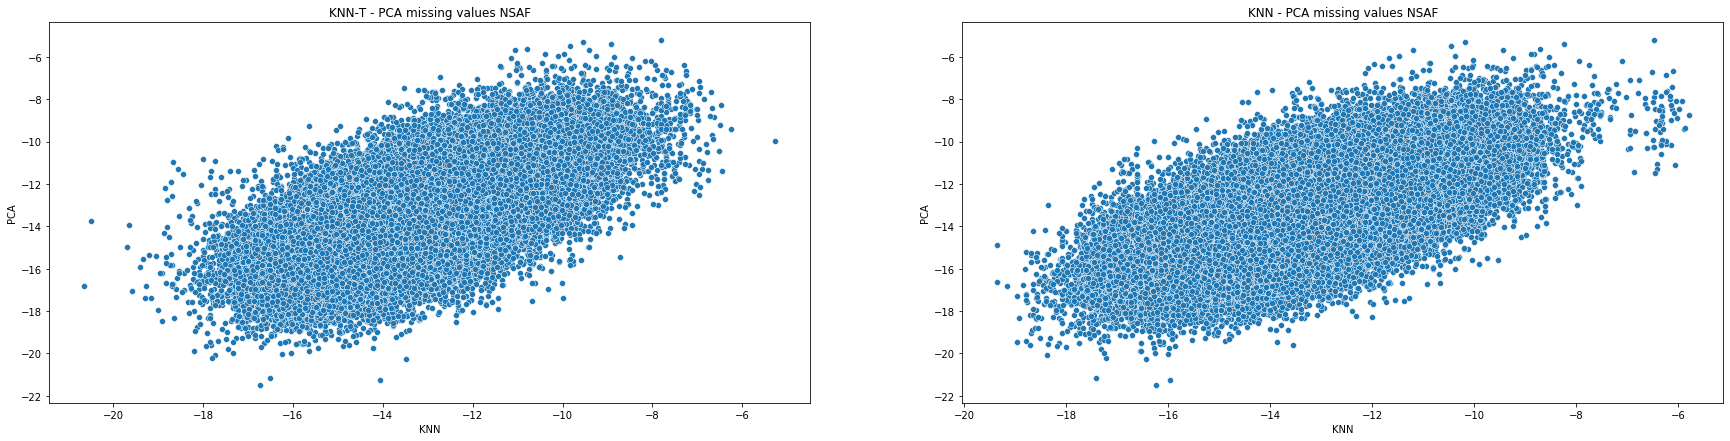

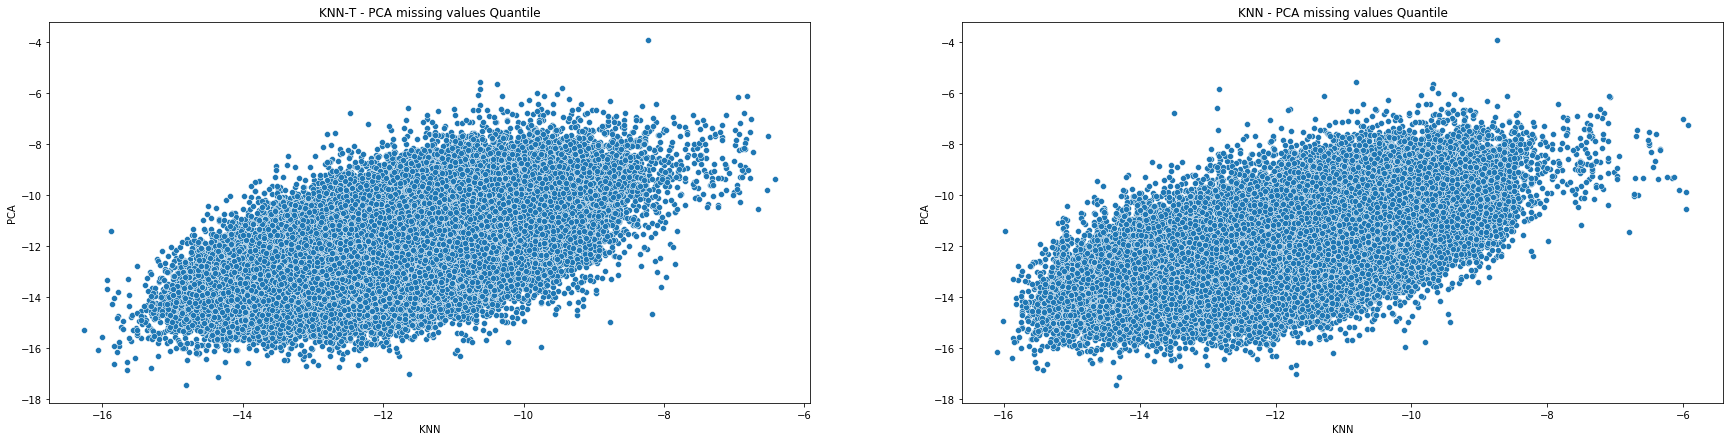

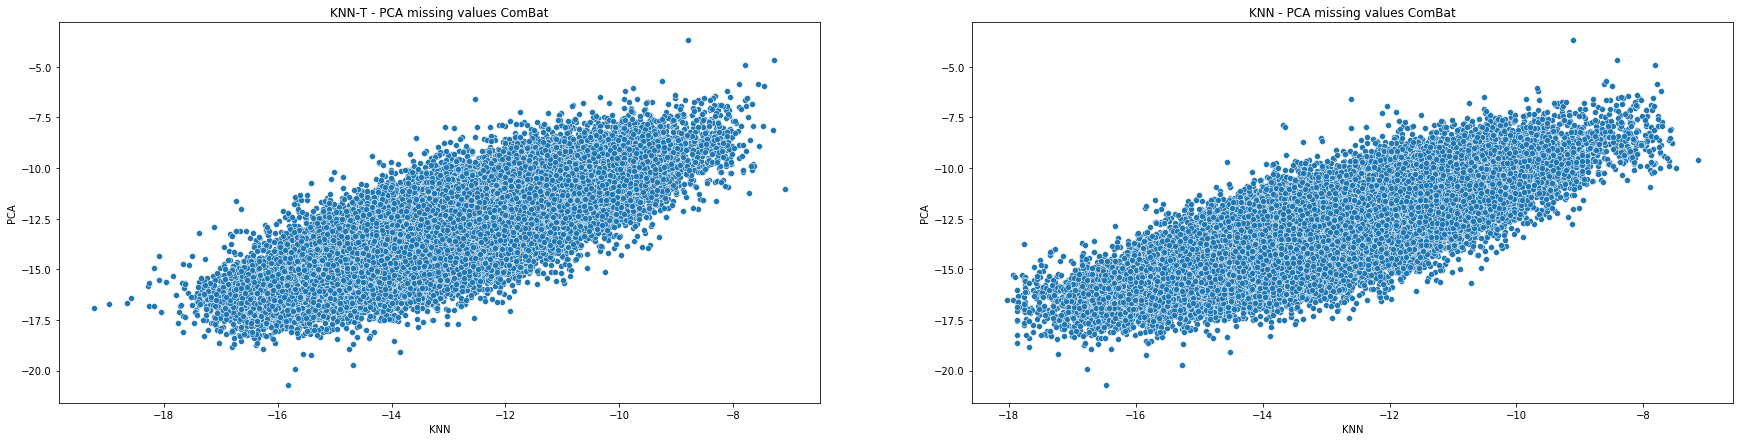

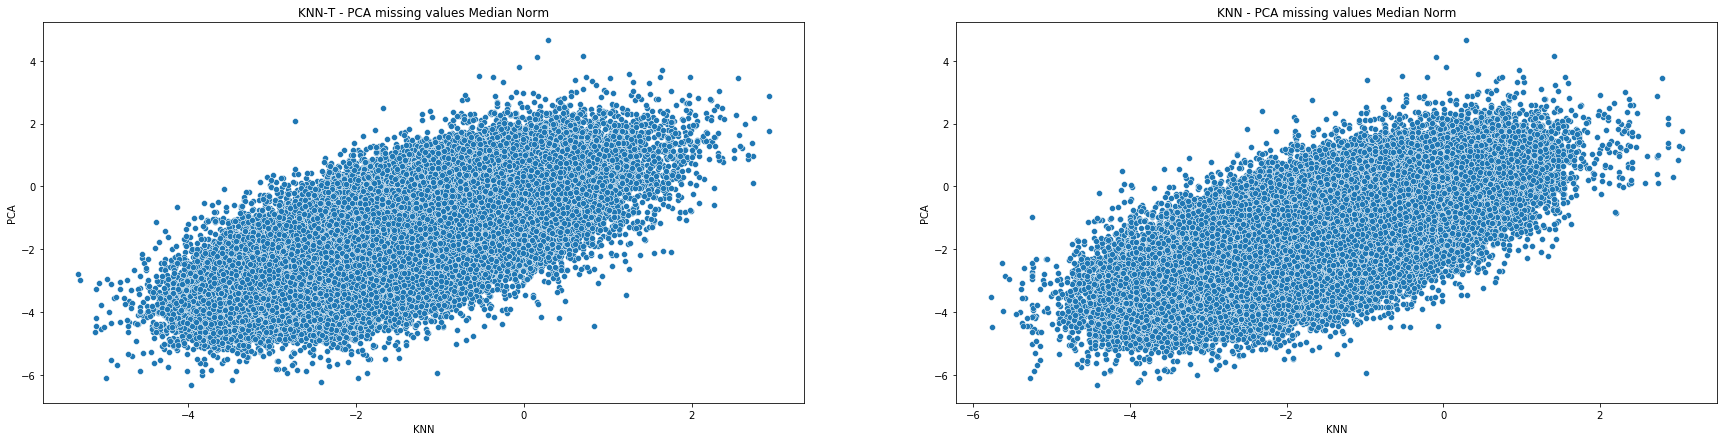

In [163]:
corr_nsaf_T, corr_nsaf = calc_corr_KNN_PCA(knn_nsaf_protein, knn_nsaf_sample, pca_nsaf, "NSAF", nsaf_scaler)
corr_quantile_T, corr_quantile = calc_corr_KNN_PCA(knn_quantile_protein, knn_quantile_sample, pca_quant, "Quantile", quantile_scaler)
corr_combat_T, corr_combat = calc_corr_KNN_PCA(knn_combat_protein, knn_combat_sample, pca_combat, "ComBat", combat_scaler)
corr_med_T, corr_med = calc_corr_KNN_PCA(knn_med_protein, knn_med_sample, pca_med_norm, "Median Norm", median_norm_scaler)

In [ ]:
estimator = Pipeline(steps=[
    ("Scaling", MinMaxScaler()),
    ("imputer", IterativeImputer(estimator=BayesianRidge(), max_iter=25, n_nearest_features=50))
    ])

BR_samples = estimator.fit_transform(data_nsaf.T)

---

# The effect of LOD imputation on the distribution of abundance values per sample

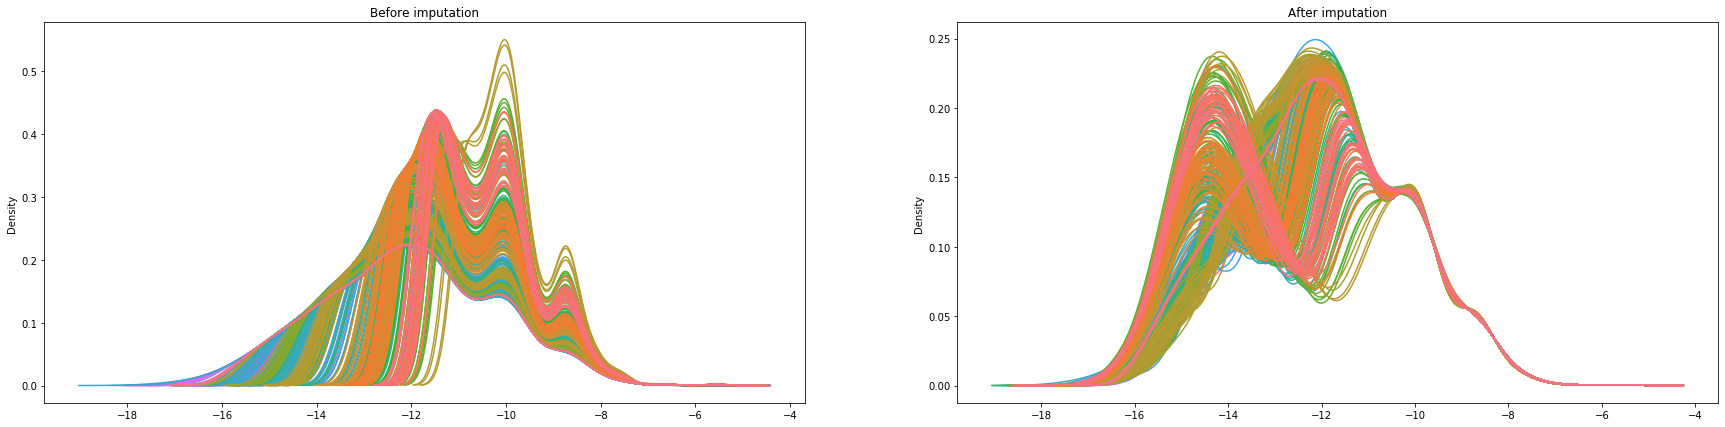

In [76]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('Before imputation')
sns.kdeplot(data=data_quantile.transpose(), legend = False, common_norm=False, ax =ax[0])

ax[1].set_title("After imputation")
sns.kdeplot(data=imputed_quantile.transpose(), legend = False, common_norm=False, ax =ax[1])

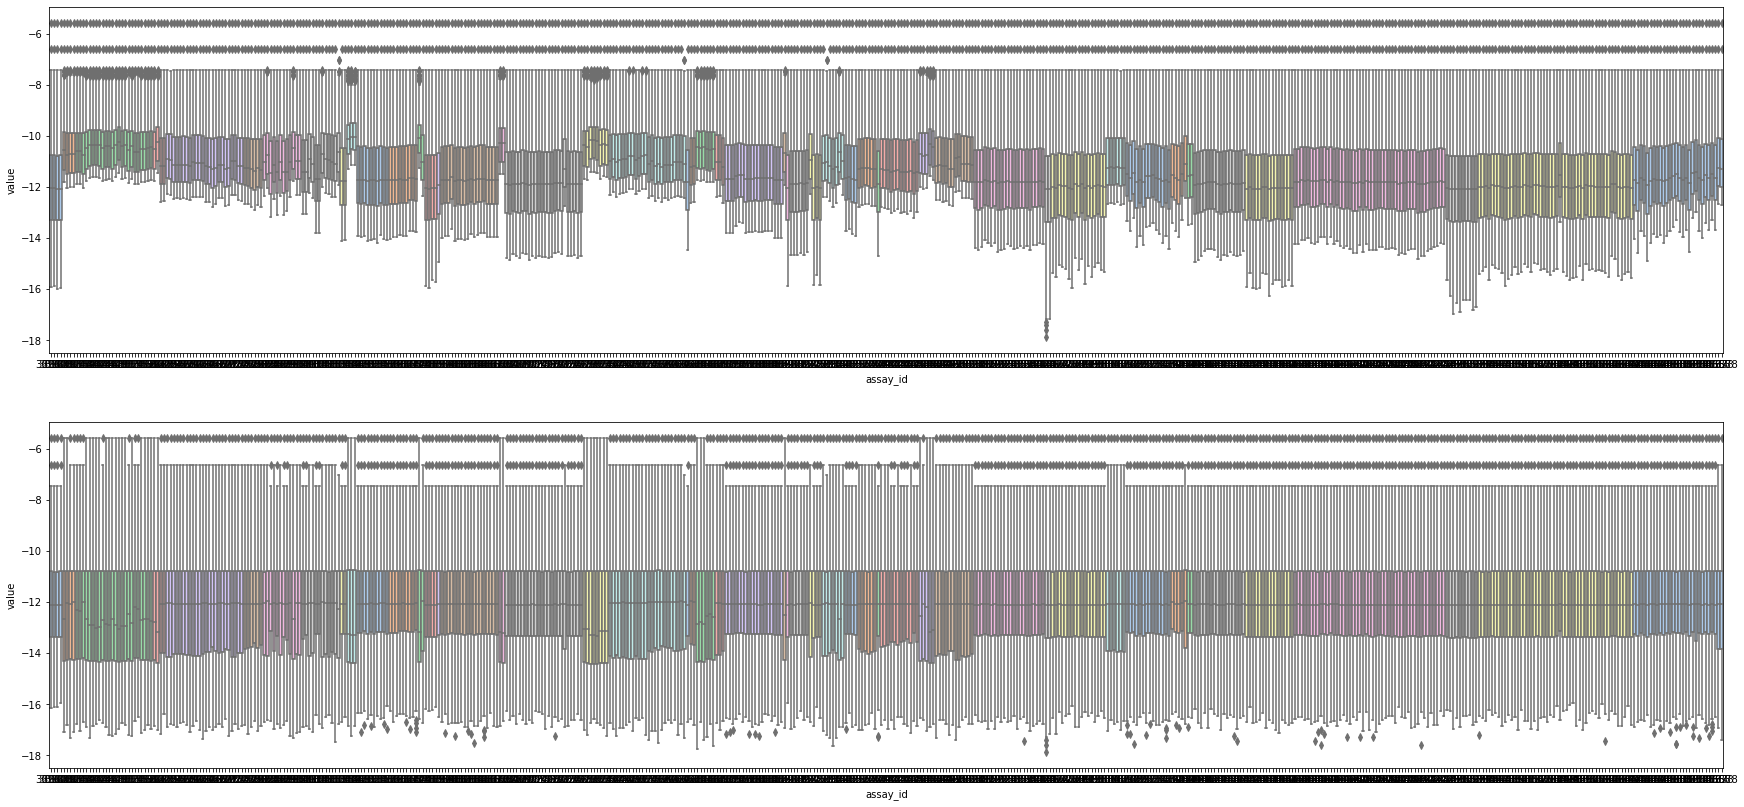

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(30,14))
ax[0].set_title('Before imputation')
ax[1].set_title("After imputation")
sns.boxplot(data=data_quantile.T.melt().dropna(), y='value', x="assay_id", ax=ax[0], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)
sns.boxplot(data=imputed_quantile.T.melt().dropna(), y='value', x="assay_id", ax=ax[1], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)

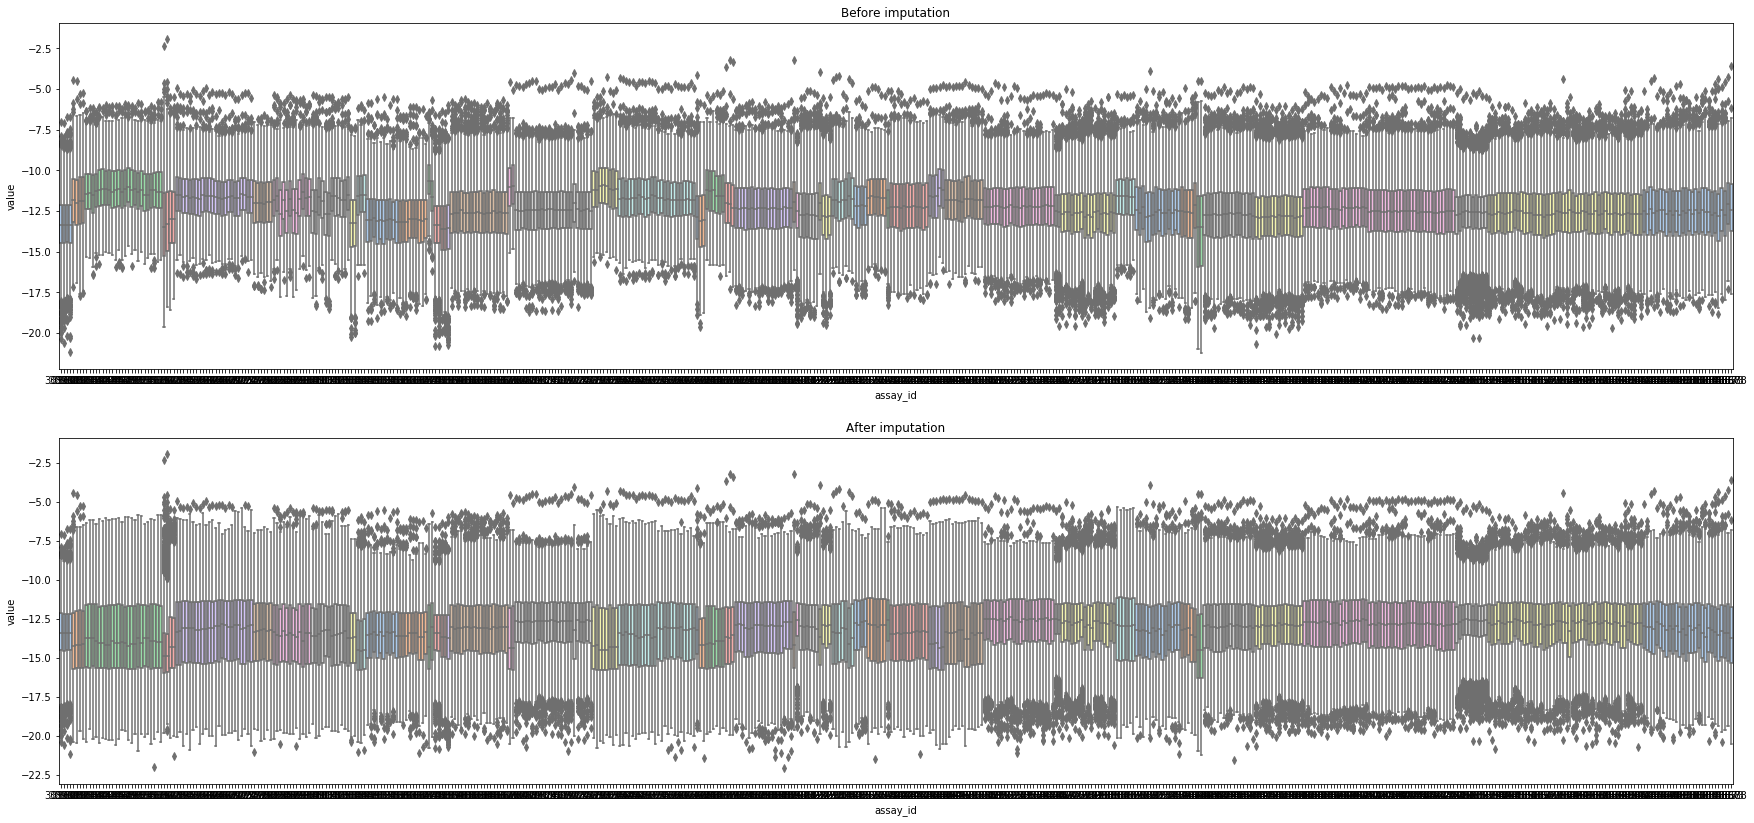

In [9]:
fig, ax = plt.subplots(2,1,figsize=(30,14))
ax[0].set_title('Before imputation')
ax[1].set_title("After imputation")
sns.boxplot(data=data_nsaf.T.melt().dropna(), y='value', x="assay_id", ax=ax[0], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)
sns.boxplot(data=imputed_nsaf.T.melt().dropna(), y='value', x="assay_id", ax=ax[1], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)

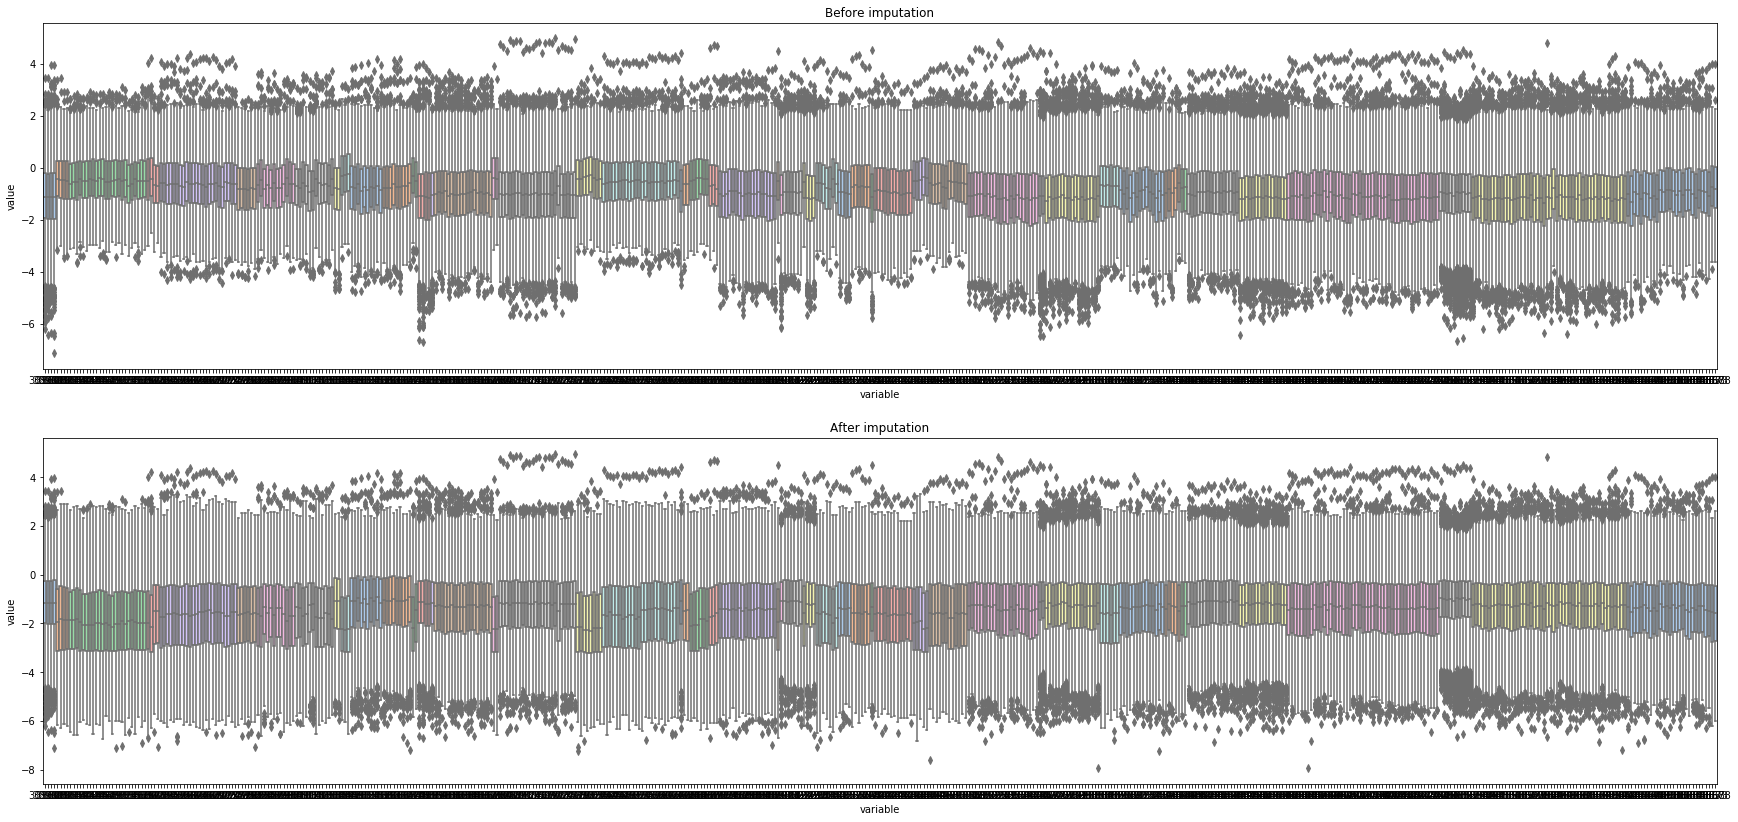

In [13]:
fig, ax = plt.subplots(2,1,figsize=(30,14))
ax[0].set_title('Before imputation')
ax[1].set_title("After imputation")
sns.boxplot(data=data_median_norm.T.melt().dropna(), y='value', x="variable", ax=ax[0], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)
sns.boxplot(data=imputed_median_norm.T.melt().dropna(), y='value', x="variable", ax=ax[1], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)

---

# Combining LOD imputation and KNN/PCA imputation

Perform LOD imputation on samples with less the protein identified in less than 20% of its samples. For the rest, impute with KNN or PCA.

For splitting strategies, perform only PCA and KNN on test set as in no way you know whether it is depleted in a certain group, because you do not know the group of the test samples

In [6]:
class MNAR_MCAR_Imputer(BaseEstimator, TransformerMixin):
    '''
    Imputes values either with left-censored gaussian or PCA/KNN imputation.

    This delineation is only made during the fit phase for training data when labels are seen.
    For test data, PCA/KNN imputation is done dependant on which one was chosen during initialization ('pca', 'knn')

    MNAR is done when > a% of a protein in a group is missing.
    For example: A0AVT1 is only found in (a=.8) 20% of samples in group Glioblastoma --> perform MNAR method for this protein for samples in Glioblastoma

    '''

    def __init__(self, missing_percentage = .8, MCAR_estimator = "pca", mean_shift=2, 
                 std_scale=.3, lowest_val=False, explained_variance=.95, max_iter=50, keep_PC_constant=True,
                 n_neighbors = 10, weights='distance'):
        
        assert MCAR_estimator in ["pca", "knn"]
        self.missing_percentage = missing_percentage
        self.MCAR_estimator = MCAR_estimator
        self.fitted = False
        self.mean_shift = mean_shift
        self.std_scale = std_scale
        self.lowest_val = lowest_val
        self.explained_variance = explained_variance
        self.max_iter = max_iter
        self.keep_PC_constant = keep_PC_constant
        self.n_neighbors = n_neighbors
        self.weights = weights

    def fit(self, X, y):
        assert len(X) == len(y)
        X = pd.DataFrame(X).reset_index(drop=True).rename(columns={X.columns[x]:x for x in range(len(X.columns))})
        
        self.mean_std_df = pd.DataFrame({"mean": X.mean(), "std": X.std()})
        
        self.mv_LOD_group = {}
        for group in np.unique(y):

            mv_perc_group = X[y==group].isna().sum() / (y==group).sum()
            self.mv_LOD_group[group] = X.columns[mv_perc_group < self.missing_percentage]
            
        return self

    def transform(self, X, y=np.array([None])):
        check_is_fitted(self, 'mean_std_df')

        # If train set is imputed and LOD must be used
        if not (y == None).all():
            
            # 1. MNAR-imputation

            X_imputed = pd.DataFrame(X).reset_index(drop=True).rename(columns={X.columns[x]:x for x in range(len(X.columns))})
            melted_df = X_imputed.melt()
            all_mv_indices = melted_df.index[melted_df.isna()["value"]]

            # Create imputation matrix. This can be accessed to compare which values would be imputed if PCA/KNN would be used for the complete dataset
            imputation_matrix = []
            for i in self.mean_std_df.index:
                m, s = self.mean_std_df.loc[i]
                imputation_matrix.append(np.random.normal(m-self.mean_shift*s, s*self.std_scale, size=len(X)))
            self.imputation_matrix = pd.DataFrame(data=imputation_matrix, index=self.mean_std_df.index).T

            # Make sure no values are imputed below 0 (when minmax normalized) (this case, no minmax is assumed)
            #self.imputation_matrix.where(self.imputation_matrix>0, other = 0, inplace=True)

            # Set imputation columns that do not fullfill MNAR-imputation condition to np.nan. This prevents imputation for certain cells.
            for group in np.unique(y):
                not_impute_columns = self.mv_LOD_group[group]
                self.imputation_matrix.loc[y==group, not_impute_columns] = np.nan
            
            for i in X_imputed.columns:
                X_imputed[i].fillna(self.imputation_matrix[i], inplace=True)

            # 2. PCA/KNN imputation
            # Store how each MV is interpreted (either MNAR or MCAR) for the training data
            melted_df = X_imputed.melt()
            self.pca_knn_mv_indices = melted_df.index[melted_df.isna()["value"]]
            self.lod_mv_indices = [x for x in all_mv_indices if x not in self.pca_knn_mv_indices] 
            
            self.X_pca_imputed, self.MSE_rescaled, self.MSEs_scaled = PCA_imputation(X_imputed, explained_variance=self.explained_variance, max_iter=self.max_iter, keep_PC_constant=self.keep_PC_constant)

            knn_imputer = KNNImputer(n_neighbors=self.n_neighbors, weights=self.weights)
            self.X_knn_imputed = knn_imputer.fit_transform(X_imputed)

            mv_knn = pd.DataFrame(self.X_knn_imputed).melt().loc[self.pca_knn_mv_indices, 'value']
            mv_pca = pd.DataFrame(self.X_pca_imputed).melt().loc[self.pca_knn_mv_indices, 'value']
                
            self.corr_knn_PCA = pearsonr(mv_knn, mv_pca)
                
            if self.MCAR_estimator == "pca":
                return self.X_pca_imputed
            elif self.MCAR_estimator == "knn":
                return self.X_knn_imputed

        # else test set must be fitted. Retrain PCA/KNN together with imputed training data
        else:
            check_is_fitted(self, 'X_pca_imputed', msg="First transform a training set by providing an array of labels to y during transform")

            X_imputed = pd.DataFrame(X, columns=self.mean_std_df.index).reset_index(drop=True)
            train_and_test = pd.concat([self.X_pca_imputed, X_imputed]).reset_index(drop=True)
            test_indices = list(range(len(self.X_pca_imputed), len(train_and_test)))

            melted_train_and_test = train_and_test.melt()
            test_mv_indices = melted_train_and_test.index[melted_train_and_test.isna()["value"]]

            self.X_pca_imputed_test, self.MSE_rescaled_test, self.MSEs_scaled_test = PCA_imputation(train_and_test, explained_variance=self.explained_variance, max_iter=self.max_iter, keep_PC_constant=self.keep_PC_constant)

            knn_imputer = KNNImputer(n_neighbors=self.n_neighbors, weights=self.weights)
            self.X_knn_imputed_test = knn_imputer.fit_transform(train_and_test)

            mv_knn = pd.DataFrame(self.X_knn_imputed_test).melt().loc[self.test_mv_indices, 'value']
            mv_pca = pd.DataFrame(self.X_pca_imputed_test).melt().loc[self.test_mv_indices, 'value']
                
            self.corr_knn_PCA_test = pearsonr(mv_knn, mv_pca)
                
            if self.MCAR_estimator == "pca":
                return self.X_pca_imputed_test
            elif self.MCAR_estimator == "knn":
                return self.X_knn_imputed_test

How does LOD imputation affect the PCA/KNN imputations?

In [138]:
labels = np.array(meta.Group)
mmi_quant = uml.MNAR_MCAR_Imputer(max_iter=15)
mmi_combat = uml.MNAR_MCAR_Imputer(max_iter=15)
mmi_med = uml.MNAR_MCAR_Imputer(max_iter=15)
mmi_nsaf = uml.MNAR_MCAR_Imputer(max_iter=15)

mmi_quant.fit(data_quantile, labels)
mmi_combat.fit(data_combat, labels)
mmi_med.fit(data_median_norm, labels)
mmi_nsaf.fit(data_nsaf, labels)

imputed_df_quant = mmi_quant.transform(data_quantile, labels)
imputed_df_combat = mmi_combat.transform(data_combat, labels)
imputed_df_med = mmi_med.transform(data_median_norm, labels)
imputed_df_nsaf = mmi_nsaf.transform(data_nsaf, labels)

First iteration: 0
iteration: 0
Components: 317
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
First iteration: 0
iteration: 0
Components: 357
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
First iteration: 0
iteration: 0
Components: 331
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
First iteration: 0
iteration: 0
Components: 326
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14


Quantile :  0.7392151695338416
ComBat :  0.8387420160474829
NSAF :  0.7577551255922522
Median Norm :  0.762068641383875


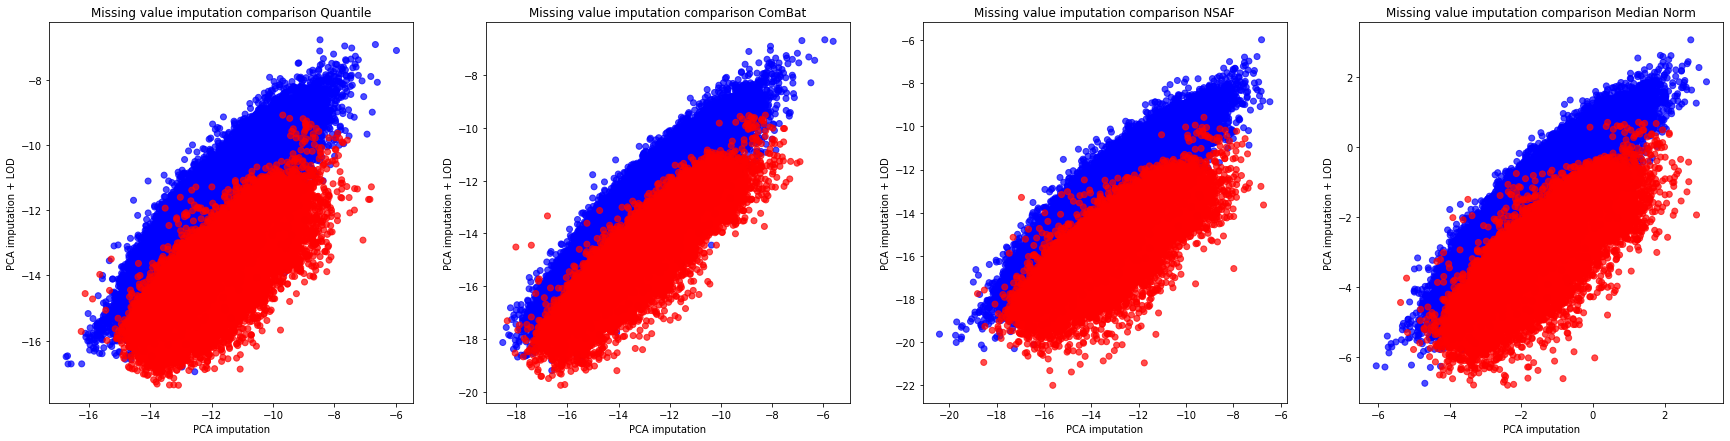

In [53]:
mcar_imputation_indices = mmi_quant.pca_knn_mv_indices
mnar_imputation_indices = mmi_quant.lod_mv_indices
colors = colors = ['b' for x in range(len(mcar_imputation_indices))] + ['r' for x in range(len(mnar_imputation_indices))]


non_lod_PCA_imputations = [pd.concat([pca_quant.melt().loc[mcar_imputation_indices,"value"], pca_quant.melt().loc[mnar_imputation_indices,"value"]]).reset_index(drop=True), 
                           pd.concat([pca_combat.melt().loc[mcar_imputation_indices,"value"], pca_combat.melt().loc[mnar_imputation_indices,"value"]]).reset_index(drop=True), 
                           pd.concat([pca_nsaf.melt().loc[mcar_imputation_indices,"value"], pca_nsaf.melt().loc[mnar_imputation_indices,"value"]]).reset_index(drop=True), 
                           pd.concat([pca_med_norm.melt().loc[mcar_imputation_indices,"value"], pca_med_norm.melt().loc[mnar_imputation_indices,"value"]]).reset_index(drop=True)]

lod_PCA_imputations = [pd.concat([imputed_df_quant.melt().loc[mcar_imputation_indices,"value"], imputed_df_quant.melt().loc[mnar_imputation_indices,"value"]]).reset_index(drop=True), 
                       pd.concat([imputed_df_combat.melt().loc[mcar_imputation_indices,"value"], imputed_df_combat.melt().loc[mnar_imputation_indices,"value"]]).reset_index(drop=True),
                       pd.concat([imputed_df_nsaf.melt().loc[mcar_imputation_indices,"value"], imputed_df_nsaf.melt().loc[mnar_imputation_indices,"value"]]).reset_index(drop=True),
                       pd.concat([imputed_df_med.melt().loc[mcar_imputation_indices,"value"], imputed_df_med.melt().loc[mnar_imputation_indices,"value"]]).reset_index(drop=True)]

fig, ax = plt.subplots(1,4, figsize=(30,7))
titles = ["Quantile", "ComBat", "NSAF", "Median Norm"]

for i,ax_ in enumerate(ax):
    ax_.set_title(f"Missing value imputation comparison {titles[i]}")
    ax_.set_xlabel("PCA imputation")
    ax_.set_ylabel("PCA imputation + LOD")

    ax_.scatter(x=non_lod_PCA_imputations[i],y=lod_PCA_imputations[i], c=colors, alpha=.7)
    print(titles[i], ": " ,pearsonr(x=non_lod_PCA_imputations[i],y=lod_PCA_imputations[i])[0])

In [58]:
least_variable_quant = pca_quant.rename(columns={x: data_quantile.columns[x] for x in range(len(pca_quant.columns))}).std().sort_values(ascending=True)

Red are missing values imputed with LOD, Blue are MVs imputed with PCA

In [143]:
def calc_corr_KNN_PCA(knn_protein, knn_sample, pca_dataset, data_norm, scaler, LOD_ids, pca_knn_ids):
    """knn_protein: imputed dataset with knn_T; others are similar"""

    fig, ax = plt.subplots(1,2, figsize= (30,7))
    for ax_ in ax:    
        ax_.set_xlabel("KNN")
        ax_.set_ylabel("PCA")

    ax[0].set_title(f"KNN-T - PCA missing values {data_norm}")
    ax[1].set_title(f"KNN - PCA missing values {data_norm}")

    mv_KNN_T = pd.DataFrame(scaler.inverse_transform(knn_protein)).melt().loc[pca_knn_ids, 'value']
    mv_KNN = pd.DataFrame(scaler.inverse_transform(knn_sample)).melt().loc[pca_knn_ids, 'value']
    mv_PCA = pca_dataset.melt().loc[pca_knn_ids, 'value']
    mv_dataframe = pd.DataFrame({"KNN-T": mv_KNN_T, "KNN": mv_KNN, "PCA": mv_PCA})
    mv_dataframe["Type"] = "MCAR"

    corr_knnT_PCA = pearsonr(mv_KNN_T, mv_PCA)
    corr_knn_PCA = pearsonr(mv_KNN, mv_PCA)

    mv_KNN_T = pd.DataFrame(scaler.inverse_transform(knn_protein)).melt().loc[LOD_ids, 'value']
    mv_KNN = pd.DataFrame(scaler.inverse_transform(knn_sample)).melt().loc[LOD_ids, 'value']
    mv_PCA = pca_dataset.melt().loc[LOD_ids, 'value']
    mv_dataframe2 = pd.DataFrame({"KNN-T": mv_KNN_T, "KNN": mv_KNN, "PCA": mv_PCA})
    mv_dataframe2["Type"] = "MNAR"

    mv_dataframe = pd.concat([mv_dataframe, mv_dataframe2])

    corr_knnT_PCA = pearsonr(mv_KNN_T, mv_PCA)
    corr_knn_PCA = pearsonr(mv_KNN, mv_PCA)

    sns.scatterplot(data=mv_dataframe, x="KNN-T", y = "PCA", hue="Type",ax=ax[0])
    sns.scatterplot(data=mv_dataframe, x="KNN", y = "PCA", hue="Type",ax=ax[1])

    print(data_norm,"(pearson KNN-T - PCA): ",  corr_knnT_PCA)
    print(data_norm,"(pearson KNN - PCA): ",  corr_knn_PCA)

    return corr_knnT_PCA[0], corr_knn_PCA[0]

([<matplotlib.patches.Wedge at 0x7f4e9a2a12d0>,
 [Text(-0.9212607815890269, 0.6010645325636635, 'MCAR'),
  Text(0.9212607815890268, -0.6010645325636637, 'MNAR')],
 [Text(-0.5025058808667419, 0.3278533813983619, '81.6%'),
  Text(0.5025058808667419, -0.32785338139836195, '18.4%')])

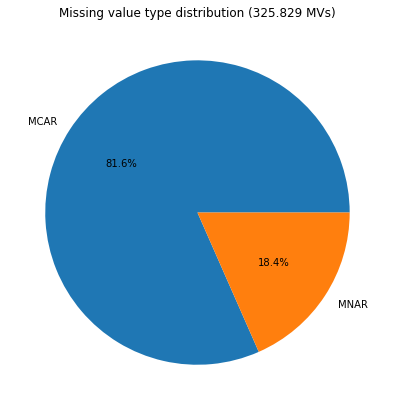

In [155]:
plt.figure(figsize=(7,7), facecolor='white')
plt.title("Missing value type distribution (325.829 MVs)")
plt.pie(x=[265873,59956], labels=['MCAR', 'MNAR'], autopct = '%1.1f%%')

Quantile Normalization (pearson KNN-T - PCA):  (0.6651562013092758, 0.0)
Quantile Normalization (pearson KNN - PCA):  (0.718394202608321, 0.0)


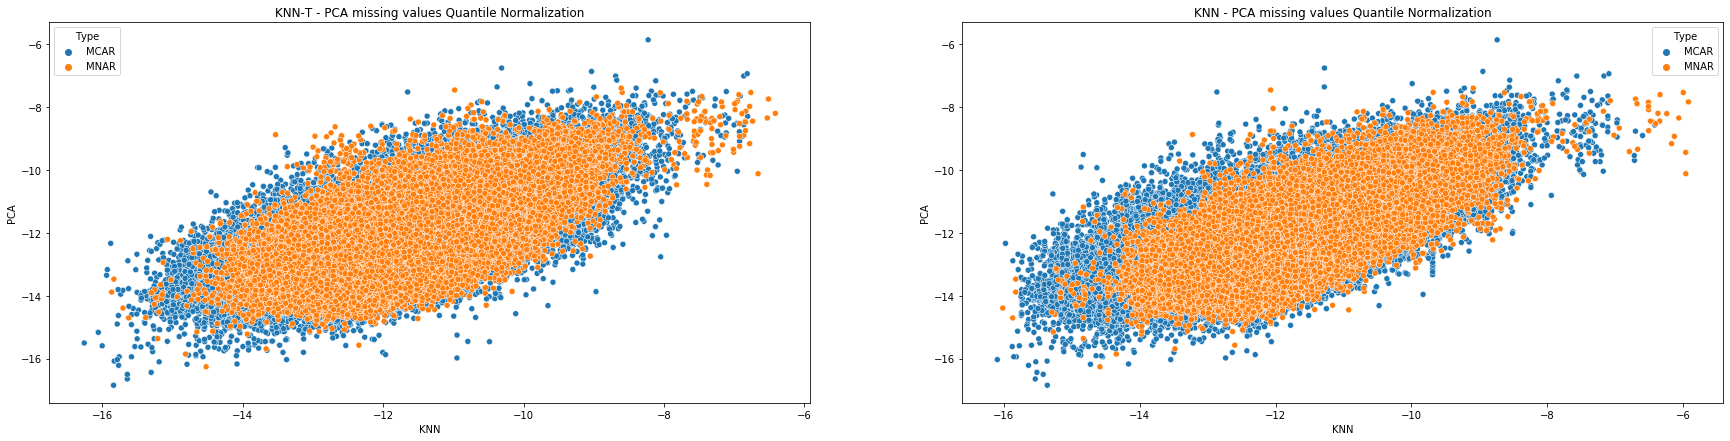

In [144]:
cor1, cor2 = calc_corr_KNN_PCA(knn_quantile_protein, knn_quantile_sample, pca_quant, "Quantile Normalization", quantile_scaler, mnar_mcar_imputer.lod_mv_indices, mnar_mcar_imputer.pca_knn_mv_indices)